In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os

dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from spec2D import Spec2D
from gaussFit import GaussFit
from ChainTool import ChainTool

sys.path.append(dir_KLens)
from KLtool import plot_specs

from IPython.display import display as ipython_display

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

In [3]:
dataInfo = gen_mock_tfCube(pars, line_species, slits='major', noise_mode=1)
spec2D = dataInfo['spec'][0]

## 0. check spec2D data

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff6282ac190>)

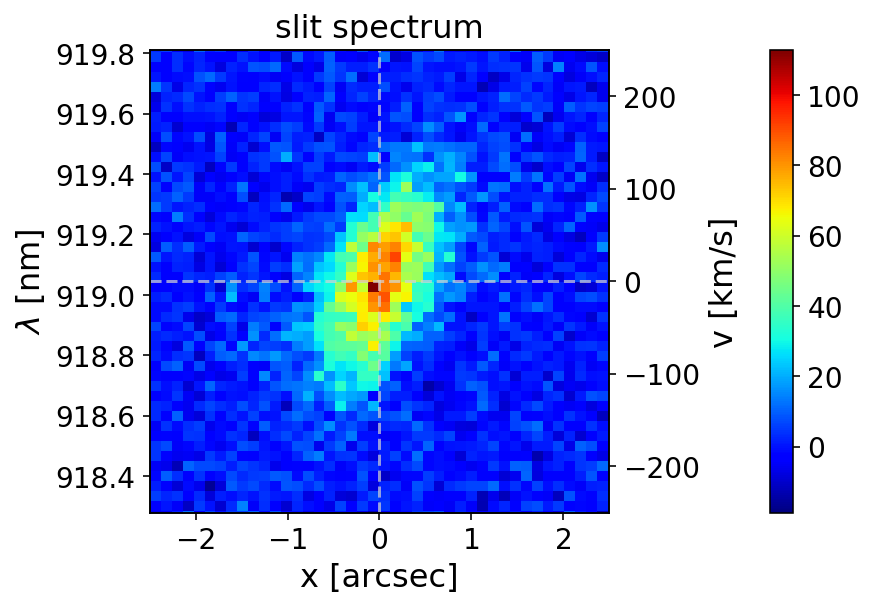

In [4]:
from binnedFit_utilities import velocity_to_lambda

ylim = velocity_to_lambda(v=[-250, 250], lambda0=656.461, z=0.4)
spec2D.display(xlim=[-2.5, 2.5], ylim=ylim, mark_cen=True)

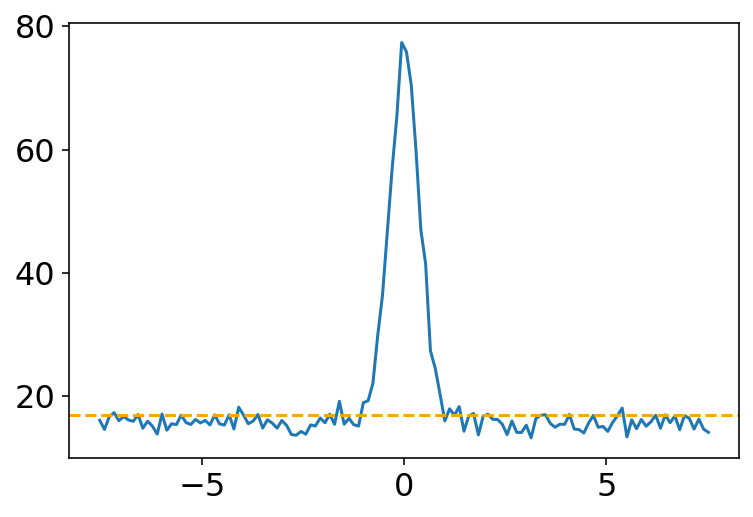

In [5]:
thresholdSNR = 17
plt.plot(spec2D.spaceGrid, spec2D.SNR_pos)
plt.axhline(y=thresholdSNR, color='orange', ls='--')

## 1. start GaussFit

In [6]:
GF = GaussFit(spec2D=spec2D)

In [7]:
GF.thresholdSNR

17.54289290759012

### 1.1 display overall best-fit model

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RuntimeError for pos_id: 9. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 12. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 13. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 18. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 26. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 27. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 30. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 44. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 47. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 89. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 90. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.4844672679901123 (secs)
RuntimeError for pos_id: 7. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 11. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 16. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 23. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 35. Set best-fit gaus

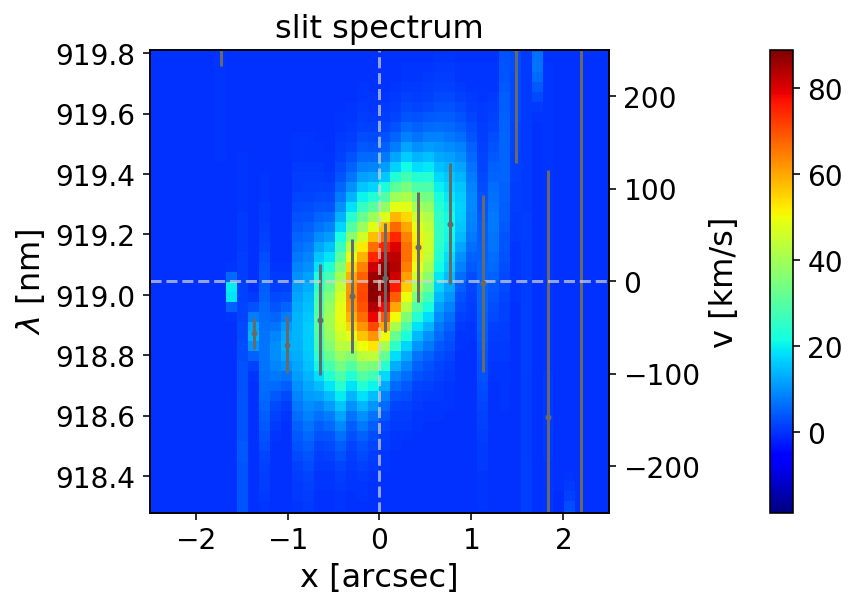

In [8]:
model2D = Spec2D(GF.model, GF.spec2D.array_var, GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                 line_species=GF.spec2D.line_species, z=GF.spec2D.z)
fig, ax = model2D.display(xlim=[-2.5,2.5], ylim=ylim, mark_fit=True)

print(f'chi2: {GF.chi2}')
print(f'reduced chi2: {GF.reduced_chi2}')

## 2. check gaussian fit in 1D for position bin i

In [9]:
GF.spec2D.array.shape

(128, 122)

SNR = 77.36
peak lambda = 919.02 nm
peak amp = 41.55 photons
1 sigma = -0.19 nm


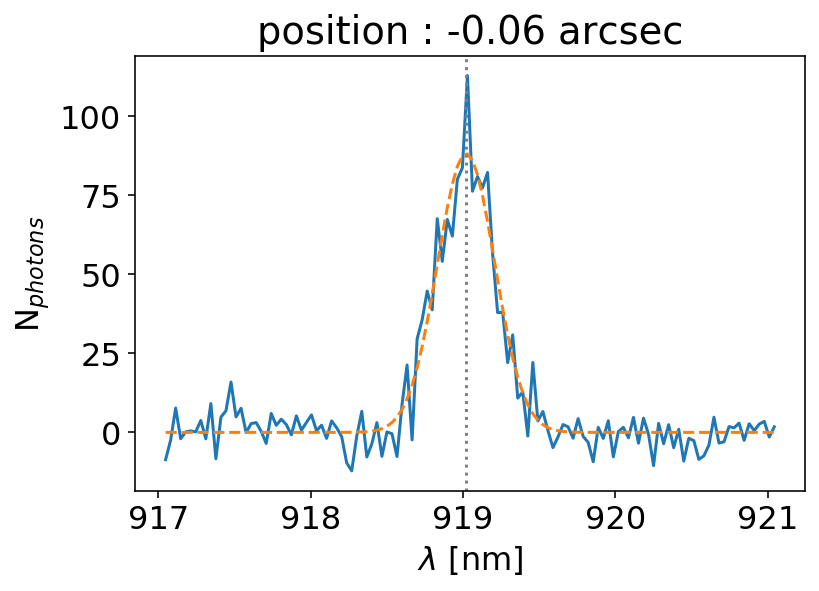

In [10]:
i=63

spec2D = dataInfo['spec'][0]
SNR = spec2D.SNR_pos

GF = GaussFit(spec2D)

best_vals = GF._fit_per_bin(pos_id=i)

# data
plt.plot(GF.spec2D.lambdaGrid, GF.spec2D.array[i])

# model
plt.plot(GF.spec2D.lambdaGrid, GF.gaussian(GF.spec2D.lambdaGrid, *best_vals), ls="--")
plt.axvline(x=best_vals[0], color='gray', ls=':')

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('N$_{photons}$')


plt.title(f'position : {GF.spec2D.spaceGrid[i]:.2f} arcsec')
print(f'SNR = {SNR[i]:.2f}')
print(f'peak lambda = {best_vals[0]:.2f} nm')
print(f'peak amp = {best_vals[1]:.2f} photons')
print(f'1 sigma = {best_vals[2]:.2f} nm')

## 3. check residual

RuntimeError for pos_id: 9. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 12. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 13. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 18. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 26. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 27. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 30. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 44. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 47. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 89. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 90. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.4240710735321045 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff628d7fed0>)

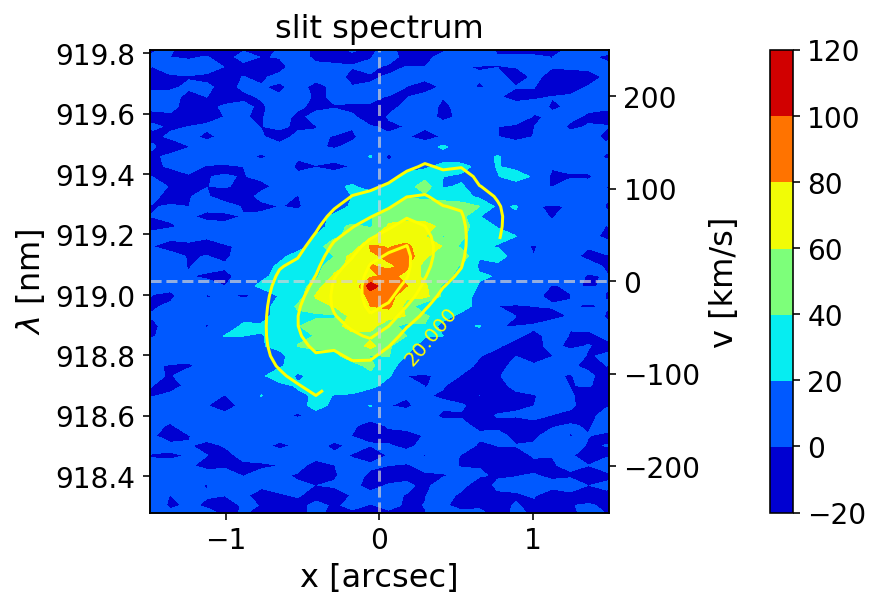

In [11]:
spec2D.display(xlim=[-1.5, 1.5], ylim=ylim, mark_cen=True, model=GF.model)

(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a85ab150>)

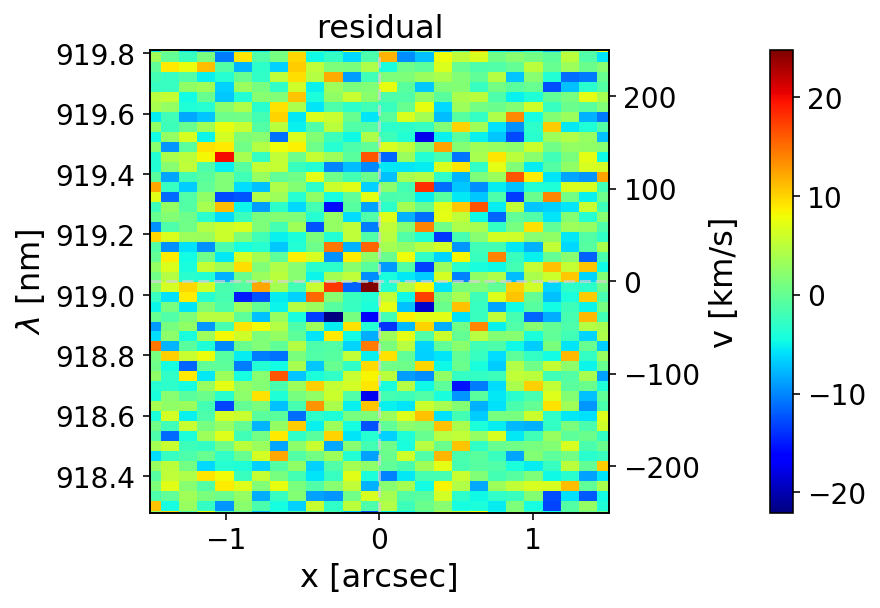

In [12]:
residual2D = Spec2D(spec2D.array-GF.model, GF.spec2D.array_var, GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                    GF.spec2D.line_species, GF.spec2D.z)

residual2D.display(xlim=[-1.5, 1.5], ylim=ylim, mark_cen=True, title='residual')

## ---------- END ----------